## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
# check gpu resource
!nvidia-smi

Tue Mar 26 10:04:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 419.35       Driver Version: 419.35       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 750    WDDM  | 00000000:01:00.0  On |                  N/A |
| 40%   27C    P8     1W /  38W |    221MiB /  1024MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [8]:
def build_mlp(input_shape, output_units=10, num_neurons=[128,64,32]):
    model=Sequential()
    model.add(Dense(units=input_shape[1],input_dim=input_shape[1],kernel_initializer='normal',activation='relu',name='input'))
    for i, n_unit in enumerate(num_neurons):
        model.add(Dense(units=n_unit, kernel_initializer='normal', activation='relu',name='hidden'+str(i+1)))
    model.add(Dense(units=output_units,kernel_initializer='normal',activation='softmax',name='output'))
    return model

In [9]:
model=build_mlp(input_shape=x_train.shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden1 (Dense)              (None, 128)               393344    
_________________________________________________________________
hidden2 (Dense)              (None, 64)                8256      
_________________________________________________________________
hidden3 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 9,844,266
Trainable params: 9,844,266
Non-trainable params: 0
_________________________________________________________________


In [10]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = [0.01]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = [0.6,0.8,1.0]

## Using nesterov

In [15]:
results = {}
"""
Build the experiment loop
"""
for momentum in MOMENTUM:
    keras.backend.clear_session() #清掉舊的graph
    print(f"Experiment with momentum = {momentum}")
    # construct model
    model=build_mlp(input_shape=x_train.shape)
    model.summary()
    # set hyper-parameters
    optimizer=keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=momentum)
    # compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    # fit model
    model.fit(x_train,y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test,y_test),
              shuffle=True)
    
    # collect results
    train_loss=model.history.history['loss']
    valid_loss=model.history.history['val_loss']
    train_acc=model.history.history['acc']
    valid_acc=model.history.history['val_acc']
    
    # construct dictionary: experiment names/ results
    exp_name_tag="exp_momentum_%s" %str(momentum)
    results[exp_name_tag]={'train_loss':train_loss,
                           'valid_loss':valid_loss,
                           'train_acc':train_acc,
                           'valid_acc':valid_acc}

Experiment with momentum = 0.6
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden1 (Dense)              (None, 128)               393344    
_________________________________________________________________
hidden2 (Dense)              (None, 64)                8256      
_________________________________________________________________
hidden3 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 9,844,266
Trainable params: 9,844,266
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epo

50000/50000 [==============================] - 7s 132us/step - loss: 0.9317 - acc: 0.6688 - val_loss: 2.0357 - val_acc: 0.4316
Experiment with momentum = 0.8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden1 (Dense)              (None, 128)               393344    
_________________________________________________________________
hidden2 (Dense)              (None, 64)                8256      
_________________________________________________________________
hidden3 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 9,844,266
Trainable params: 9,844,266
Non-trainable params: 0
________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.9594 - acc: 0.2776 - val_loss: 1.8701 - val_acc: 0.3259
Epoch 2/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.7961 - acc: 0.3493 - val_loss: 1.7965 - val_acc: 0.3377
Epoch 3/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.8153 - acc: 0.3423 - val_loss: 1.9056 - val_acc: 0.3239
Epoch 4/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.1755 - acc: 0.2496 - val_loss: 2.3896 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.8304 - acc: 0.0962 - val_loss: 2.9035 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.6784 - acc: 0.1003 - val_loss: 2.7217 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.6510 - acc: 0.1004 - val_loss: 2.7569 - 

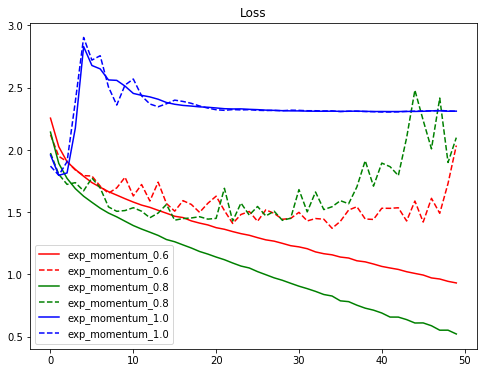

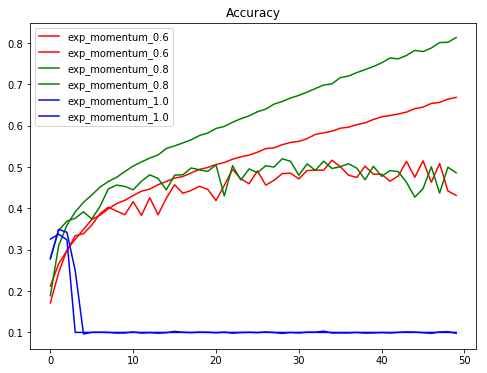

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar=['r','g','b','y','m','k']
"""
Draw the results
"""
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'],'--', label=cond, color=color_bar[i])
plt.title('Loss')
plt.legend()
plt.show

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'], '-', label=cond, color=color_bar[i])
plt.title('Accuracy')
plt.legend()
plt.show()

## Not using neterov

In [18]:
results2 = {}
"""
Build the experiment loop
"""
for momentum in MOMENTUM:
    keras.backend.clear_session() #清掉舊的graph
    print(f"Experiment with momentum = {momentum}")
    # construct model
    model2=build_mlp(input_shape=x_train.shape)
    model2.summary()
    # set hyper-parameters (nesterov=False)
    optimizer=keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=False, momentum=momentum)
    # compile model
    model2.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    # fit model
    model2.fit(x_train,y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test,y_test),
              shuffle=True)
    
    # collect results
    train_loss=model2.history.history['loss']
    valid_loss=model2.history.history['val_loss']
    train_acc=model2.history.history['acc']
    valid_acc=model2.history.history['val_acc']
    
    # construct dictionary: experiment names/ results
    exp_name_tag="exp_momentum_%s" %str(momentum)
    results2[exp_name_tag]={'train_loss':train_loss,
                            'valid_loss':valid_loss,
                            'train_acc':train_acc,
                            'valid_acc':valid_acc}

Experiment with momentum = 0.6
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden1 (Dense)              (None, 128)               393344    
_________________________________________________________________
hidden2 (Dense)              (None, 64)                8256      
_________________________________________________________________
hidden3 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 9,844,266
Trainable params: 9,844,266
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [===========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 131us/step - loss: 2.1320 - acc: 0.2120 - val_loss: 1.9746 - val_acc: 0.2838
Epoch 2/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.8746 - acc: 0.3196 - val_loss: 1.8807 - val_acc: 0.3232
Epoch 3/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.7681 - acc: 0.3591 - val_loss: 1.7808 - val_acc: 0.3521
Epoch 4/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.6915 - acc: 0.3871 - val_loss: 1.6584 - val_acc: 0.4043
Epoch 5/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.6386 - acc: 0.4084 - val_loss: 1.6153 - val_acc: 0.4187
Epoch 6/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.5875 - acc: 0.4289 - val_loss: 1.5685 - val_acc: 0.4338
Epoch 7/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.5404 - acc: 0.4456 - val_loss: 1.5639 - 

Epoch 2/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.0655 - acc: 0.2188 - val_loss: 2.1292 - val_acc: 0.1623
Epoch 3/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.3510 - acc: 0.1236 - val_loss: 2.4239 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.4308 - acc: 0.0995 - val_loss: 2.5148 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.4261 - acc: 0.1006 - val_loss: 2.4944 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.4350 - acc: 0.0987 - val_loss: 2.3937 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.4544 - acc: 0.0985 - val_loss: 2.3629 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.4582 - acc: 0.1007 - val_loss: 2.4470 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==========

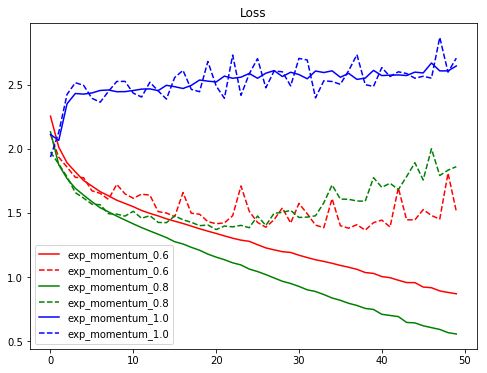

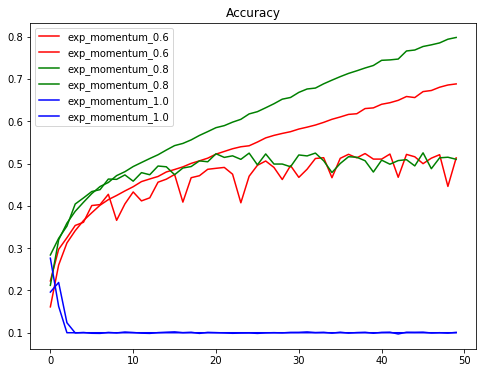

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar=['r','g','b','y','m','k']
"""
Draw the results
"""
plt.figure(figsize=(8,6))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train_loss'])), results2[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid_loss'])), results2[cond]['valid_loss'],'--', label=cond, color=color_bar[i])
plt.title('Loss')
plt.legend()
plt.show

plt.figure(figsize=(8,6))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train_acc'])), results2[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid_acc'])), results2[cond]['valid_acc'], '-', label=cond, color=color_bar[i])
plt.title('Accuracy')
plt.legend()
plt.show()